In [1]:
%load_ext dotenv
%dotenv
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['WANDB_NOTEBOOK_NAME'] = 'New GAN.ipynb'

In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
from keras.utils import (
    to_categorical,
)  # Only for categorical one hot encoding
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds
import tensorboard
import keras
from keras import layers
from tensorflow_datasets.core.utils import gcs_utils
import os
gcs_utils._is_gcs_disabled = True
import datetime
from IPython.display import clear_output
import tqdm
import pickle
import timeit

2024-04-28 18:54:32.527137: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 18:54:32.551687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 18:54:32.952156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mrwhite0racle/

In [3]:
s_wandb_available = False
try:
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    is_wandb_available = True
except Exception as e:
    print("Wandb not available")
    print(e)

# !rm -rf ./logs/
RANDOM_SEED=42
MODEL_NAME = 'NewGAN'

try: 
    from google.colab import drive
    drive.mount('/content/gdrive')
    MODEL_PATH = os.path.join('/content/gdrive/My Drive/AI Research/GANs/models/', MODEL_NAME)
except Exception as e:
    MODEL_PATH = os.path.join('models', MODEL_NAME)

TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME) # Sets up a log directory.
# Make sure these directories exist
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(TRAIN_LOGDIR, exist_ok=True)
# Start a profiler server before your model runs.
tf.profiler.experimental.server.start(6009)

2024-04-28 18:54:33.836611: I external/local_tsl/tsl/profiler/rpc/profiler_server.cc:46] Profiler server listening on [::]:6009 selected port:6009


In [4]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL('libcudart.so')
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int*1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible=True

keras.config.set_image_data_format('channels_last')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2024-04-28 18:54:39.133803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 18:54:39.153883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 18:54:39.154001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
# precision_policy = keras.mixed_precision.Policy('mixed_float16')
precision_policy = keras.mixed_precision.Policy('float32')
keras.mixed_precision.set_global_policy(precision_policy)
tf.keras.mixed_precision.set_global_policy(precision_policy)

tf.debugging.set_log_device_placement(True)

In [6]:
normalizeImage = lambda x: tf.divide(tf.subtract(tf.cast(x, dtype=precision_policy.compute_dtype), 127.5), 127.5)
denormalizeImage = lambda x: tf.cast(tf.add(tf.multiply(x, 127.5), 127.5), dtype=tf.uint8)

def plotImages(imgs):
    fig = plt.figure(figsize=(8, 8))

    for i in range(imgs.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

In [7]:
class EqualizeLearningRate(layers.Wrapper):
    """
    Reference from WeightNormalization implementation of TF Addons
    EqualizeLearningRate wrapper works for keras CNN and Dense (RNN not tested).
    ```python
      net = EqualizeLearningRate(
          layers.Conv2D(2, 2, activation='relu'),
          input_shape=(32, 32, 3),
          data_init=True)(x)
      net = EqualizeLearningRate(
          layers.Conv2D(16, 5, activation='relu'),
          data_init=True)(net)
      net = EqualizeLearningRate(
          layers.Dense(120, activation='relu'),
          data_init=True)(net)
      net = EqualizeLearningRate(
          layers.Dense(n_classes),
          data_init=True)(net)
    ```
    Arguments:
      layer: a layer instance.
    Raises:
      ValueError: If `Layer` does not contain a `kernel` of weights
    """

    def __init__(self, layer, **kwargs):
        super(EqualizeLearningRate, self).__init__(layer, **kwargs)
        self._track_trackable(layer, name="layer")
        self.is_rnn = isinstance(self.layer, layers.RNN)

    def build(self, input_shape):
        """Build `Layer`"""
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = layers.InputSpec(shape=[None] + input_shape[1:])

        if not self.layer.built:
            self.layer.build(input_shape)

        kernel_layer = self.layer.cell if self.is_rnn else self.layer

        if not hasattr(kernel_layer, "kernel"):
            raise ValueError(
                "`EqualizeLearningRate` must wrap a layer that"
                " contains a `kernel` for weights"
            )

        if self.is_rnn:
            kernel = kernel_layer.recurrent_kernel
        else:
            kernel = kernel_layer.kernel

        # He constant
        self.fan_in, self.fan_out = self._compute_fans(kernel.shape)
        self.he_constant = tf.Variable(
            1.0 / np.sqrt(self.fan_in), dtype=tf.float32, trainable=False
        )

        self.v = kernel
        self.built = True

    def call(self, inputs, training=True):
        """Call `Layer`"""
        # Multiply the kernel with the he constant.
        kernel = self.v  # * self.he_constant

        if self.is_rnn:
            print(self.is_rnn)
            self.layer.cell.recurrent_kernel = kernel
            update_kernel = tf.identity(self.layer.cell.recurrent_kernel)
        else:
            self.layer.kernel = kernel
            # update_kernel = tf.identity(self.layer.kernel)

        # Ensure we calculate result after updating kernel.
        # with tf.control_dependencies([update_kernel]):
        outputs = self.layer(inputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.layer.compute_output_shape(input_shape).as_list())

    def _compute_fans(self, shape, data_format="channels_last"):
        """
        From Official Keras implementation
        Computes the number of input and output units for a weight shape.
        # Arguments
            shape: Integer shape tuple.
            data_format: Image data format to use for convolution kernels.
                Note that all kernels in Keras are standardized on the
                `channels_last` ordering (even when inputs are set
                to `channels_first`).
        # Returns
            A tuple of scalars, `(fan_in, fan_out)`.
        # Raises
            ValueError: in case of invalid `data_format` argument.
        """
        if len(shape) == 2:
            fan_in = shape[0]
            fan_out = shape[1]
        elif len(shape) in {3, 4, 5}:
            # Assuming convolution kernels (1D, 2D or 3D).
            # TH kernel shape: (depth, input_depth, ...)
            # TF kernel shape: (..., input_depth, depth)
            if data_format == "channels_first":
                receptive_field_size = np.prod(shape[2:])
                fan_in = shape[1] * receptive_field_size
                fan_out = shape[0] * receptive_field_size
            elif data_format == "channels_last":
                receptive_field_size = np.prod(shape[:-2])
                fan_in = shape[-2] * receptive_field_size
                fan_out = shape[-1] * receptive_field_size
            else:
                raise ValueError("Invalid data_format: " + data_format)
        else:
            # No specific assumptions.
            fan_in = np.sqrt(np.prod(shape))
            fan_out = np.sqrt(np.prod(shape))
        return fan_in, fan_out

@keras.saving.register_keras_serializable()
class SelfAttention(layers.Layer):
    def __init__(self, channelReduce=1, name=None, initializers="glorot_uniform", **kwargs):
        super(SelfAttention, self).__init__(name=name, **kwargs)
        self.channelReduce = channelReduce
        self.initializers = initializers

    def get_config(self):
        config = {"name": self.name}
        base_config = super(SelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def get_weights(self):
        return [self.gamma, self.kernel_f, self.kernel_g, self.kernel_h]

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.filters_f_g = self.channels // self.channelReduce
        self.filters_h = self.channels

        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(
            name="gamma", shape=[1], initializer="zeros", trainable=True
        )
        self.kernel_f = self.add_weight(
            shape=kernel_shape_f_g,
            initializer=self.initializers,
            name="kernel_f",
            trainable=True,
        )
        self.kernel_g = self.add_weight(
            shape=kernel_shape_f_g,
            initializer=self.initializers,
            name="kernel_g",
            trainable=True,
        )
        self.kernel_h = self.add_weight(
            shape=kernel_shape_h,
            initializer=self.initializers,
            name="kernel_h",
            trainable=True,
        )

        super(SelfAttention, self).build(input_shape)
        self.built = True

    def call(self, input):
        # input = [NHWC]
        f_x = tf.nn.conv2d(input, filters=self.kernel_f, strides=(1, 1), padding="SAME")
        g_x = tf.nn.conv2d(input, filters=self.kernel_g, strides=(1, 1), padding="SAME")
        h_x = tf.nn.conv2d(input, filters=self.kernel_h, strides=(1, 1), padding="SAME")

        f_x_flat = hw_flatten(f_x)  # [N(HW)C]
        g_x_flat = hw_flatten(g_x)  # [N(HW)C]

        s = keras.backend.batch_dot(g_x_flat, keras.backend.permute_dimensions(f_x_flat, (0, 2, 1)))

        beta = tf.nn.softmax(s, axis=-1)
        o = keras.backend.batch_dot(beta, hw_flatten(h_x))

        o = tf.reshape(o, shape=tf.shape(input))  # [bs, h, w, C]
        x = self.gamma * o + input
        return x

@keras.saving.register_keras_serializable()
class PixelNorm(keras.Layer):
    def __init__(self, epsilon=1e-8, **kwargs):
        super(PixelNorm, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs):
        # Calculate the square of each element
        squared_values = tf.square(inputs)
        # Calculate the mean of the squared values across the channel dimension
        mean_squared_values = tf.reduce_mean(squared_values, axis=-1, keepdims=True)
        # Add epsilon for numerical stability before taking the square root
        scaling_factor = tf.math.rsqrt(mean_squared_values + self.epsilon)
        # Normalize the inputs by the scaling factor
        normalized_inputs = inputs * scaling_factor
        return normalized_inputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(PixelNorm, self).get_config()
        config.update({'epsilon': self.epsilon})
        return config

@keras.saving.register_keras_serializable()
class FadeAdd(layers.Layer):
    def __init__(self, alpha = None, **kwargs):
        super(FadeAdd, self).__init__(**kwargs)
        if alpha is None:
            self.alpha = tf.Variable(initial_value=0.0, trainable=False)
        elif not isinstance(alpha, tf.Variable):
            self.alpha = tf.Variable(initial_value=alpha, trainable=False)
        else:
            self.alpha = alpha

    def incrementAlpha(self, step=0.1):
        self.alpha.assign(tf.minimum(self.alpha + step, 1.0))
        # Debug print to check the value of alpha if needed
        # print("New Alpha: ", self.alpha)

    def call(self, inputs):
        new, old = inputs
        return (new * self.alpha) + (old * (1 - self.alpha))

    def get_config(self):
        config = super().get_config()
        config.update({"alpha": self.alpha.numpy()})
        return config

    def compute_output_shape(self, input_shape):
        # Assuming the input is a list of two elements, both having the same shape
        if isinstance(input_shape, list) and len(input_shape) == 2:
            return input_shape[0]  # both 'new' and 'old' inputs should have the same shape
        else:
            raise ValueError("FadeAdd layer should be called on a list of two inputs.")

@keras.saving.register_keras_serializable()
class MinibatchStddev(layers.Layer):
    def __init__(self, group_size=4, name=None, **kwargs):
        super(MinibatchStddev, self).__init__(name=name, **kwargs)
        self.group_size = group_size

    def call(self, inputs):
        group_size = tf.minimum(self.group_size, tf.shape(inputs)[0])
        shape = tf.shape(inputs)
        minibatch = tf.reshape(inputs, (group_size, -1, shape[1], shape[2], shape[3]))
        stddev = tf.sqrt(tf.reduce_mean(tf.square(minibatch - tf.reduce_mean(minibatch, axis=0)), axis=0) + 1e-8)
        stddev = tf.reduce_mean(stddev, axis=[1, 2, 3], keepdims=True)
        stddev = tf.tile(stddev, [group_size, shape[1], shape[2], 1])
        return tf.concat([inputs, stddev], axis=-1)

    def get_config(self):
        config = super(MinibatchStddev, self).get_config()
        config.update({'group_size': self.group_size})
        return config

@tf.function(jit_compile=True)
def hw_flatten(x):
    inp_shape = tf.shape(x)
    # inp_shape = x.shape
    batch_size, height, width, channels = inp_shape[0], inp_shape[1], inp_shape[2], inp_shape[3]
    shape = [batch_size, height * width, channels]
    return tf.reshape(x, shape=shape)

def layer_init_stddev(shape, gain=np.sqrt(2)):
    """Get the He initialization scaling term."""
    fan_in = np.prod(shape[:-1])
    return gain / np.sqrt(fan_in)

# @keras.saving.register_keras_serializable()
class FakeLayer(layers.Layer):
    def __init__(self, layer, name=None, **kwargs):
        super(FakeLayer, self).__init__(name=name, **kwargs)
        self.layer = layer
        # self.trainable = True

    def call(self, input):
        return self.layer(input)

    def get_config(self):
        config = {"name": self.name, "layer": self.layer}
        base_config = super(FakeLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def buildModel(layers, inpTensor):
    layer = inpTensor
    # print("Rebasing")
    for i in range(len(layers)):
        # print("Adding layer: ", layer, " -> ", layers[i])
        layer = layers[i](layer)
    # print("Done")
    return layer

@keras.saving.register_keras_serializable()
class PixelReshuffle(keras.Layer):
    def __init__(self, upscale_factor, **kwargs):
        super(PixelReshuffle, self).__init__(**kwargs)
        self.upscale_factor = upscale_factor

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.upscale_factor)

    def compute_output_shape(self, input_shape):
        height, width, channels = input_shape[1], input_shape[2], input_shape[3]
        new_height = height * self.upscale_factor
        new_width = width * self.upscale_factor
        new_channels = channels // (self.upscale_factor ** 2)
        return (input_shape[0], new_height, new_width, new_channels)

    def get_config(self):
        config = super(PixelReshuffle, self).get_config()
        config.update({"upscale_factor": self.upscale_factor})
        return config

# def pixelReshuffle(x, upscale_factor):
#     return tf.nn.depth_to_space(x, upscale_factor)

class DepthToSpace(layers.Layer):
    def __init__(self, block_size, **kwargs):
        super().__init__(**kwargs)
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = keras.shape(input)
        depth = depth // (self.block_size**2)

        x = keras.ops.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = keras.transpose(x, [0, 1, 3, 2, 4, 5])
        x = keras.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x


In [8]:
# from keras.src.utils.numerical_utils import normalize

# @tf.function
# @tf.function(jit_compile=True)
def normalized_weights(vector_u: tf.Variable, kernel: tf.Variable, kernel_shape: tf.shape, power_iterations: int):
    """Generate spectral normalized weights.
    This method returns the updated value for `self.kernel` with the
    spectral normalized value, so that the layer is ready for `call()`.
    """
    weights = tf.reshape(kernel, [-1, kernel_shape[-1]])
    vec_u_val = vector_u.value

    for _ in range(power_iterations):
        vector_v = tf.nn.l2_normalize(
            tf.matmul(vec_u_val, weights, transpose_b=True), axis=None
        )
        vec_u_val = tf.nn.l2_normalize(tf.matmul(vector_v, weights), axis=None)
    # vector_u = tf.stop_gradient(vector_u)
    # vector_v = tf.stop_gradient(vector_v)
    sigma = tf.matmul(
        tf.matmul(vector_v, weights), vec_u_val, transpose_b=True
    )
    kernel_val = tf.reshape(tf.divide(kernel, sigma), kernel_shape)
    return vec_u_val, kernel_val

# @tf.function
def spectral_normalize_weights(vector_u: tf.Variable, kernel: tf.Variable, kernel_shape: tf.shape, power_iterations: int):
    # new_vector_u, new_kernel = tf.cond(
    #     tf.reduce_sum(kernel.value) == 0.0,
    #     lambda: (vector_u.value, kernel.value),
    #     lambda: normalized_weights(vector_u, kernel, kernel_shape, power_iterations)
    # )
    new_vector_u, new_kernel = normalized_weights(vector_u, kernel, kernel_shape, power_iterations)
    vector_u.assign(new_vector_u)
    kernel.assign(new_kernel)

@keras.saving.register_keras_serializable()
class SpectralNormalization(layers.Wrapper):
    def __init__(self, layer, power_iterations=1, **kwargs):
        super().__init__(layer, **kwargs)
        if power_iterations <= 0:
            raise ValueError(
                "`power_iterations` should be greater than zero. Received: "
                f"`power_iterations={power_iterations}`"
            )
        self.power_iterations = power_iterations
        self.is_separable_conv = isinstance(layer, keras.layers.SeparableConv2D)

    def build(self, input_shape):
        super().build(input_shape)
        self.input_spec = layers.InputSpec(shape=[None] + list(input_shape[1:]))

        if self.is_separable_conv:
            self.kernel_depthwise = self.layer.depthwise_kernel
            self.kernel_pointwise = self.layer.pointwise_kernel
            self.kernel_depthwise_shape = self.kernel_depthwise.shape
            self.kernel_pointwise_shape = self.kernel_pointwise.shape
            self.vector_u_depthwise = self.add_weight(
                shape=(1, self.kernel_depthwise_shape[-1]),
                initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                trainable=False,
                name="vector_u_depthwise",
                dtype=self.kernel_depthwise.dtype,
            )
            self.vector_u_pointwise = self.add_weight(
                shape=(1, self.kernel_pointwise_shape[-1]),
                initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                trainable=False,
                name="vector_u_pointwise",
                dtype=self.kernel_pointwise.dtype,
            )
        else:
            if hasattr(self.layer, "kernel"):
                self.kernel = self.layer.kernel
            elif hasattr(self.layer, "embeddings"):
                self.kernel = self.layer.embeddings
            else:
                raise ValueError(
                    f"{type(self.layer).__name__} object has no attribute 'kernel' "
                    "nor 'embeddings'"
                )
            self.kernel_shape = self.kernel.shape
            self.vector_u = self.add_weight(
                shape=(1, self.kernel_shape[-1]),
                initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                trainable=False,
                name="vector_u",
                dtype=self.kernel.dtype,
            )

    def call(self, inputs, training=False):
        if training:
            if self.is_separable_conv:
                spectral_normalize_weights(
                    self.vector_u_depthwise,
                    self.kernel_depthwise,
                    self.kernel_depthwise_shape,
                    self.power_iterations,
                )
                spectral_normalize_weights(
                    self.vector_u_pointwise,
                    self.kernel_pointwise,
                    self.kernel_pointwise_shape,
                    self.power_iterations,
                )
            else:
                spectral_normalize_weights(
                    self.vector_u, self.kernel, self.kernel_shape, self.power_iterations
                )

        output = self.layer(inputs)
        return output

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def get_config(self):
        config = {"power_iterations": self.power_iterations}
        base_config = super().get_config()
        return {**base_config, **config}



In [9]:

fmap_base = 8192
fmap_max = 512
fmap_decay = 1.0

def nf(stage):
    return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)

class GeneratorBuilder():
    def __init__(self,
                latent_dim=512, start_res=4,
                conv_normalizer: layers.Layer=FakeLayer,
                normal_normalizer=PixelNorm,
                activation_builder: lambda : layers.Layer=lambda : layers.LeakyReLU(alpha=0.2),
                upsampling_builder: lambda : layers.Layer=lambda : layers.UpSampling2D((2, 2), interpolation='bilinear'),
                kernel_constraint=None,
                kernel_initializer_builder=lambda:keras.initializers.RandomNormal(mean=0.0, stddev=0.02)(),
                freeze_oldlayers=False,
                use_sepconv=False,
                deviation_loss=keras.losses.mean_absolute_error,
                **kwargs,
            ):
        self.conv_normalizer = conv_normalizer
        self.activation_builder = activation_builder
        self.normal_normalizer = normal_normalizer
        self.general_layer_configs = {
            "kernel_constraint": kernel_constraint,
            "kernel_initializer": kernel_initializer_builder(),
            "use_bias": False,
        }
        self.conv_layer_configs = {
            **self.general_layer_configs,
            "padding": "same",
        }
        self.separableconv_layer_configs = {
            "use_bias": False,
            "padding": "same",
            "depthwise_constraint": kernel_constraint,
            "depthwise_initializer": kernel_initializer_builder(),
            "pointwise_constraint": kernel_constraint,
            "pointwise_initializer": kernel_initializer_builder(),
        }
        self.current_res = None
        self.start_res = start_res
        self.latent_dim = latent_dim
        self.upsampling_builder = upsampling_builder
        self.freeze_oldlayers = freeze_oldlayers
        self.use_sepconv = use_sepconv
        self.downscaler = layers.AveragePooling2D((2, 2))
        self.global_block_id = 0
        self.deviation_loss = deviation_loss

    def gen_block_name(self, res, blocktype, suffix='', use_blockid=True):
        prefix = f'gen_{res}x{res}_{blocktype}'
        if use_blockid == True:
            blockid = self.global_block_id
            self.global_block_id += 1
            if suffix == '':
                return f"{prefix}-{blockid}"
            return f"{prefix}-{blockid}_{suffix}"
        else:
            if suffix == '':
                return f"{prefix}"
            return f"{prefix}_{suffix}"

    def freeze_layers(self):
        for layer in self.current_model.layers:
            layer.trainable = False

    def unfreeze_layers(self):
        for layer in self.current_model.layers:
            layer.trainable = True

    def make_conv(self, res, features, kernel_size=(3, 3), blockid=0, suffix=""):
        if self.use_sepconv == True:
            return self.conv_normalizer(layers.SeparableConv2D(features, kernel_size=kernel_size, **self.separableconv_layer_configs), name=self.gen_block_name(res, "sepconv", suffix))
        else:
            return self.conv_normalizer(layers.Conv2D(features, kernel_size=kernel_size, **self.conv_layer_configs), name=self.gen_block_name(res, "conv", suffix))

    def make_output_block(self, res, input_tensor):
        output_tensor = self.conv_normalizer(
            layers.Conv2D(3, kernel_size=(1, 1), **self.conv_layer_configs),
            name=self.gen_block_name(res, 'conv', 'output', use_blockid=False)
        )(input_tensor)
        output_tensor = layers.Activation('tanh', name=self.gen_block_name(res, "output", use_blockid=False))(output_tensor)
        return output_tensor

    def build_base(self, latent_dim, start_res):
        log_res = int(np.log2(start_res))
        features = nf(log_res - 1)

        input_tensor = layers.Input(shape=(latent_dim,))

        x = layers.Reshape((start_res, start_res, latent_dim // ((start_res)**2)))(input_tensor)
        x = PixelNorm()(x)
        # PixelReshuffle(2)
        x = self.conv_normalizer(layers.Conv2D(features, kernel_size=(1, 1),**self.conv_layer_configs), name=self.gen_block_name(start_res, "conv", "base_first"))(x)
        x = self.activation_builder()(x)
        x = self.normal_normalizer()(x)

        x = self.make_conv(start_res, features, kernel_size=(3, 3), suffix="base")(x)
        x = self.activation_builder()(x)
        x = self.normal_normalizer()(x)

        x = self.make_conv(start_res, features, kernel_size=(3, 3), suffix="base")(x)
        x = self.activation_builder()(x)
        x = self.normal_normalizer(name=self.gen_block_name(start_res, "final", use_blockid=False))(x)

        output_tensor = self.make_output_block(start_res, x)

        print("Generator base built with shape ", output_tensor.shape)
        self.current_model = keras.Model(inputs=input_tensor, outputs=output_tensor)
        self.current_model.compile(run_eagerly=False, jit_compile=True)
        self.higher_model = None
        self.current_res = start_res

    def add_stage(self, res=0, freeze_previous_output=False, alpha=0, **kwargs):
        if res == 0:
            res = self.current_res * 2
            assert res == self.current_model.output.shape[1] * 2
        log_res = int(np.log2(res))
        features = nf(log_res - 1)
        # We need to add stage after the last layer

        if not isinstance(alpha, tf.Variable):
            print("GEN: Alpha is None, creating new alpha variable")
            alpha = tf.Variable(alpha, dtype=precision_policy.compute_dtype, trainable=False)
        else:
            print("GEN: Alpha is Variable")

        if self.freeze_oldlayers:
            self.freeze_layers()

        last_final_tensor = self.current_model.get_layer(self.gen_block_name(res // 2, "final", use_blockid=False)).output
        print("Adding stage ", res)
        x = PixelReshuffle(2)(last_final_tensor)    # Upscale
        # x = pixelReshuffle(last_final_tensor, 2)

        x = self.make_conv(res, features, kernel_size=(3, 3))(x)
        x = self.activation_builder()(x)
        x = self.normal_normalizer()(x)

        x = self.make_conv(res, features, kernel_size=(3, 3), blockid=1)(x)
        x = self.activation_builder()(x)
        x = self.normal_normalizer(name=self.gen_block_name(res, "final", use_blockid=False))(x)

        output_tensor = self.make_output_block(res, x)      # 16x16 RGB Image Output
        input_tensor = self.current_model.input
        last_output_tensor = self.current_model.get_layer(self.gen_block_name(res // 2, "output", use_blockid=False)).output

        last_output_upscaled = self.upsampling_builder()(last_output_tensor)
        output_tensor = FadeAdd(alpha=alpha)([output_tensor, last_output_upscaled])

        self.current_model = keras.Model(inputs=input_tensor, outputs=output_tensor)
        self.current_model.compile(run_eagerly=False, jit_compile=True)
        self.lower_model = keras.Model(inputs=input_tensor, outputs=last_final_tensor)
        self.lower_model.compile(run_eagerly=False, jit_compile=True)
        self.higher_model = keras.Model(inputs=last_final_tensor, outputs=[last_output_tensor, output_tensor])
        self.higher_model.compile(run_eagerly=False, jit_compile=True)

        self.current_res = res
        if freeze_previous_output == True:
            self.set_last_output_trainable(False)

    def set_last_output_trainable(self, trainable=True):
        if self.higher_model == None:
            return
        # print("Setting last output trainable: ", trainable, "for res ", self.current_res)
        last_conv_output_layer : keras.layers.Layer = self.higher_model.get_layer(self.gen_block_name(self.current_res // 2, "conv", "output", use_blockid=False))
        last_conv_output_layer.trainable = trainable

    def grow(self, res=0, alpha=0.0, **kwargs):
        print("Growing to ", res, "Arguments: ", kwargs)
        if self.current_res is None:
            self.build_base(self.latent_dim, self.start_res)
            # self.composite_predict = tf.function(self._fallback_composite_predict, jit_compile=False)
            self.composite_predict = self._fallback_composite_predict
        else:
            self.add_stage(res, alpha=alpha, **kwargs)
            # self.composite_predict = tf.function(self._true_composite_predict, jit_compile=False)
            self.composite_predict = self._true_composite_predict
        # self.predict = tf.function(self._predict, jit_compile=False)
        self.predict = self._predict
        # return self.model

    def get_layers(self):
        if self.higher_model == None:
            return self.current_model.layers
        return self.lower_model.layers + self.higher_model.layers

    def _predict(self, input, training=False) -> tf.Tensor:
        return self.current_model(input, training=training)

    def _fallback_composite_predict(self, input, training=True):
        if self.higher_model == None:
            preds = self.predict(input, training=training)
            return preds, None, None, 0.0

    def _true_composite_predict(self, input, training=True):
        preds = self.lower_model(input, training=training)
        lower_out, higher_out = self.higher_model(preds, training=True)
        high_to_low = self.downscaler(higher_out)
        # print(lower_out.shape, higher_out.shape, high_to_low.shape)
        dev_loss = self.deviation_loss(lower_out, high_to_low)
        return higher_out, lower_out, high_to_low, tf.reduce_mean(dev_loss)

    def get_trainable_variables(self):
        if self.higher_model == None:
            return self.current_model.trainable_variables
        else:
            return self.higher_model.trainable_variables + self.lower_model.trainable_variables

class DescriminatorBuilder():
    def __init__(self,
                start_res=4,
                conv_normalizer: layers.Layer=SpectralNormalization,
                normal_normalizer=lambda: FakeLayer(lambda x: x),
                activation_builder: lambda : layers.Layer=lambda : layers.LeakyReLU(alpha=0.2),
                kernel_constraint=None,
                kernel_initializer_builder=lambda:keras.initializers.RandomNormal(mean=0.0, stddev=0.02)(),
                freeze_oldlayers=False,
                use_sepconv=False,
                **kwargs,
            ):
        self.conv_normalizer = conv_normalizer
        self.activation_builder = activation_builder
        self.normal_normalizer = normal_normalizer
        self.general_layer_configs = {
            "kernel_constraint": kernel_constraint,
            "kernel_initializer": kernel_initializer_builder(),
            "use_bias": False,
        }
        self.conv_layer_configs = {
            **self.general_layer_configs,
            "padding": "same",
        }
        self.separableconv_layer_configs = {
            "use_bias": False,
            "padding": "same",
            "depthwise_constraint": kernel_constraint,
            "depthwise_initializer": kernel_initializer_builder(),
            "pointwise_constraint": kernel_constraint,
            "pointwise_initializer": kernel_initializer_builder(),
        }
        self.current_res = None
        self.start_res = start_res
        self.freeze_oldlayers = freeze_oldlayers
        self.use_sepconv = use_sepconv
        self.global_block_id = 0
        print("Use SepConv: ", self.use_sepconv)

    def gen_block_name(self, res, blocktype, suffix='', use_blockid=True):
        prefix = f'des_{res}x{res}_{blocktype}'
        if use_blockid == True:
            blockid = self.global_block_id
            self.global_block_id += 1
            if suffix == '':
                return f"{prefix}-{blockid}"
            return f"{prefix}-{blockid}_{suffix}"
        else:
            if suffix == '':
                return f"{prefix}"
            return f"{prefix}_{suffix}"

    def freeze_layers(self):
        for layer in self.model.layers:
            layer.trainable = False

    def unfreeze_layers(self):
        for layer in self.model.layers:
            layer.trainable = True

    def make_conv(self, res, features, kernel_size=(3, 3), blockid=0, suffix=""):
        if self.use_sepconv == True:
            return self.conv_normalizer(layers.SeparableConv2D(features, kernel_size=kernel_size, **self.separableconv_layer_configs), name=self.gen_block_name(res, "sepconv", suffix))
        else:
            return self.conv_normalizer(layers.Conv2D(features, kernel_size=kernel_size, **self.conv_layer_configs), name=self.gen_block_name(res, "conv", suffix))

    def build_base(self, start_res):
        log_res = int(np.log2(start_res))
        features = nf(log_res - 1)

        input_tensor = layers.Input(shape=(start_res, start_res, 3))

        initial_layers = []
        # initial_layers.append(MinibatchStddev())
        initial_layers.append(self.make_conv(start_res, features, kernel_size=(1, 1), suffix="base_extractor"))
        initial_layers.append(self.normal_normalizer())
        initial_layers.append(self.activation_builder())

        main_layers = []
        main_layers.append(MinibatchStddev())
        main_layers.append(self.make_conv(start_res, features, kernel_size=(3, 3), suffix="base"))
        main_layers.append(self.normal_normalizer())
        main_layers.append(self.activation_builder())

        main_layers.append(layers.Flatten())
        # layers.GlobalAveragePooling2D())
        main_layers.append(layers.Dense(1, name="output_logit", **self.general_layer_configs))

        output_tensor = buildModel(initial_layers + main_layers, input_tensor)

        self.main_layers = main_layers
        self.initial_layers = initial_layers

        self.model = keras.Model(inputs=input_tensor, outputs=output_tensor)
        self.model.compile(run_eagerly=False, jit_compile=True)
        self.current_res = start_res
        self.old_model_cloned = self.model

    def add_stage(self, res=0, alpha=0, **kwargs):
        if res == 0:
            res = self.current_res * 2
            assert res == self.model.input.shape[1] * 2
        log_res = int(np.log2(res))
        features = nf(log_res - 1)
        lowerFeatures = nf(log_res - 2)

        if not isinstance(alpha, tf.Variable):
            print("DES: Alpha is None, creating new alpha variable")
            alpha = tf.Variable(alpha, dtype=precision_policy.compute_dtype, trainable=False)
        else:
            print("DES: Alpha is Variable")

        if self.freeze_oldlayers:
            for layer in self.initial_layers:
                layer.trainable = False

            for layer in self.main_layers:
                layer.trainable = False

        # We need to add stage before all the main layers

        input_layer = layers.Input(shape=(res, res, 3))
        print("Adding stage ", res)
        downscaled = layers.AveragePooling2D((2, 2))(input_layer)
        old_downscaled_tensor = buildModel(self.initial_layers, downscaled)

        new_initial_layers = []
        # new_initial_layers.append(MinibatchStddev())
        new_initial_layers.append(self.make_conv(res, features, kernel_size=(1, 1), suffix="extractor"))
        new_initial_layers.append(self.normal_normalizer())
        new_initial_layers.append(self.activation_builder())

        new_main_layers = []
        # Add self-attention layer conditionally based on resolution
        # if res >= 16:
        #     new_SelfAttention(name="attention_{res}".format(res=res)))

        # new_MinibatchStddev())
        new_main_layers.append(self.make_conv(res, features, kernel_size=(3, 3), suffix=""))
        new_main_layers.append(self.normal_normalizer())
        new_main_layers.append(self.activation_builder())

        # Add self-attention layer conditionally based on resolution
        # if res >= 16:
        #     new_SelfAttention(name="attention2_{res}".format(res=res)))

        new_main_layers.append(self.make_conv(res, lowerFeatures, kernel_size=(3, 3), suffix=""))
        new_main_layers.append(self.normal_normalizer())
        new_main_layers.append(self.activation_builder())

        new_main_layers.append(layers.AveragePooling2D((2, 2)))

        new_downscaled_tensor = buildModel(new_initial_layers + new_main_layers, input_layer)

        alphaLayer = FadeAdd(alpha)
        new_downscaled_tensor = alphaLayer([new_downscaled_tensor, old_downscaled_tensor])

        print("New downscaled tensor: ", new_downscaled_tensor)

        output_tensor = buildModel(self.main_layers, new_downscaled_tensor)

        self.main_layers = new_main_layers + self.main_layers
        self.initial_layers = new_initial_layers
        # self.old_model_cloned = keras.models.clone_model(self.model)
        self.model.save('tmp.keras')
        self.old_model_cloned = keras.models.load_model('tmp.keras', custom_objects={
            "FadeAdd": FadeAdd,
            "MinibatchStddev": MinibatchStddev,
            "SelfAttention": SelfAttention,
            "SpectralNormalization": SpectralNormalization,
            "FakeLayer": FakeLayer,
        })
        self.old_model_cloned.trainable = False
        self.old_model_cloned.compile(run_eagerly=False, jit_compile=True)
        self.old_model_original = self.model
        self.model = keras.Model(inputs=input_layer, outputs=output_tensor)
        self.model.compile(run_eagerly=False, jit_compile=True)
        self.current_res = res

    def grow(self, res=0, alpha=0.0, **kwargs) -> keras.Model:
        print("Growing to ", res, "Arguments: ", kwargs)
        if self.current_res is None:
            self.build_base(self.start_res)
        else:
            self.add_stage(res, alpha=alpha, **kwargs)
        # self.predict = tf.function(self._predict, jit_compile=False)
        self.predict = self._predict
        return self.model

    def _predict(self, input, training=False) -> tf.Tensor:
        return self.model(input, training=training)
    
    def get_trainable_variables(self):
        return self.model.trainable_variables

In [10]:
def lerp(a, b, t):
    return a + (b - a) * t

def generate_input_data(batch_size=64):
    return tf.random.normal([batch_size, 512])

def discriminator_wgan_loss(real_output, fake_output):
    # wgan_loss = fake_output - real_output
    # return wgan_loss
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss

def generator_wgan_loss(fake_output):
    total_loss = -tf.reduce_mean(fake_output)
    return total_loss

# @tf.function
def descriminator_hinge_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
    fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
    des_loss = real_loss + fake_loss
    return des_loss

# @tf.function
def generator_hinge_loss(fake_output):
    total_loss = -tf.reduce_mean(fake_output)
    return total_loss

# @tf.function
def descriminator_softplus_loss(real_output, fake_output):
    des_loss = tf.nn.softplus(fake_output) + tf.nn.softplus(-real_output)
    return tf.reduce_mean(des_loss)

# @tf.function
def generator_softplus_loss(fake_output):
    return tf.reduce_mean(tf.nn.softplus(-fake_output))

def generator_enc_loss(real, fake):
    # return tf.reduce_mean(tf.abs(real - fake))
    return tf.abs(real - fake)

# @tf.function
def gradientPenalty(des, real_images, fake_images):
    with tf.GradientTape() as tape:
        batch_size = tf.shape(real_images)[0]
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0, dtype=fake_images.dtype)
        interpolates = epsilon * real_images + (1 - epsilon) * fake_images
        tape.watch(interpolates)
        pred = des(interpolates, training=True)
    grads = tape.gradient(pred, [interpolates])[0]
    l2norm = tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.size(tf.shape(grads))))
    norm = tf.sqrt(l2norm)
    loss = tf.square(norm - 1)
    loss = tf.reduce_mean(loss)
    return loss

# @tf.function
def gradientPenaltyAlt(des, real_images, fake_images):
    with tf.GradientTape() as tape:
        batch_size = tf.shape(real_images)[0]
        epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0, dtype=fake_images.dtype)
        interpolates = epsilon * real_images + (1 - epsilon) * fake_images
        tape.watch(interpolates)
        pred = des(interpolates, training=True)
    grads = tape.gradient(pred, [interpolates])[0]
    l2norm = tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.size(tf.shape(grads))))
    # loss = l2norm
    loss = tf.reduce_mean(l2norm)
    return loss

# @tf.function
def r1Penalty(des, real_images, fake_images):
    with tf.GradientTape() as tape:
        tape.watch(real_images)
        pred = des(real_images, training=True)
        # pred = tf.reduce_sum(pred)
    grads = tape.gradient(pred, [real_images])[0]
    l2norm = tf.reduce_sum(tf.square(grads), axis=tf.range(1, tf.size(tf.shape(grads))))
    loss = tf.reduce_mean(l2norm)
    # print("Type of loss: ", loss.dtype, real_images.dtype, grads.dtype)"
    return loss

In [11]:
class FakeStrategyScope():
    def __init__(self):
      pass
     
    def __enter__(self):
      pass
 
    def __exit__(self, *args):
      pass

class FakeStrategy():
    def __init__(self):
        pass

    def scope(self):
        return FakeStrategyScope()


In [12]:

def augmenter(size, alpha=None, method='area'):
  if alpha is not None:
    @tf.function()
    def augment(sample):
      image = (tf.cast(sample['image'], precision_policy.compute_dtype) - 127.5) / 127.5
      big = tf.image.resize(image, [size, size], method=method, antialias=True)
      small =  tf.image.resize(image, [size//2, size//2], method=method, antialias=True)
      small = tf.image.resize(small, [size, size], method='area')
      image = (big*alpha.alpha) + (small*(1-alpha.alpha))
      image = tf.image.random_flip_left_right(image)
      return {'image':image}
    return augment
  else:
    @tf.function()
    def augment(sample):
      image = (tf.cast(sample['image'], precision_policy.compute_dtype) - 127.5) / 127.5
      image = tf.image.resize(image, [size, size], method=method, antialias=True)
      image = tf.image.random_flip_left_right(image)
      return {'image':image}
    return augment


class ProGANMonitor(keras.callbacks.Callback):
    metrics_description_table = {
        "des_loss": "Descriminator Loss Raw",
        "des_main_loss": "Descriminator core loss",
        "des_gradient_penalty":"Descriminator gradient penalty",
        "des_drift_loss": "Descriminator drift loss",

        "gen_loss": "Generator Loss Raw",
        "gen_anchor_loss": "Generator Anchor Loss",
        "gen_deviation_loss": "Generator Deviation Loss",
        "gen_main_loss": "Generator core loss",
    }
    def __init__(self, 
                 batch_size, 
                 sample_real_data, 
                 name=None, 
                 tf_log_dir=None, 
                 sample_noise=None,
                 ):
        super().__init__()
        self.sample_real_data = sample_real_data
        if sample_noise != None:
            self.sample_noise = sample_noise
        else:
            self.sample_noise = generate_input_data(batch_size=batch_size)
        self.batch_size = batch_size
        self.results = []
        self.tf_writer = tf.summary.create_file_writer(os.path.join(tf_log_dir, 'train'))

    def compile(self, model, **kwargs):
        self.global_train_step = model.train_step_counter.value()
        self.steps_per_epoch = model.steps_per_epoch
        print("Compiled Monitor with global train step: ", self.global_train_step, "Steps per epoch: ", self.steps_per_epoch)

    def evaluate(self, batches=10):
        desAcc = 0
        genLoss = 0
        gen : GeneratorBuilder = self.model.genBuilder
        des : DescriminatorBuilder = self.model.desBuilder
        for _ in range(batches):
            real = self.sample_real_data
            fake = gen.predict(generate_input_data(batch_size=self.batch_size), training=False)

            real_output = des.predict(real, training=False)
            fake_output = des.predict(fake, training=False)

            output = tf.concat((fake_output, real_output), axis=0)

            labels = tf.reshape(
                tf.concat(
                    (tf.zeros_like(fake_output), tf.ones_like(real_output)), axis=0
                ),
                [-1],
            )
            output = tf.reshape(output, [-1])

            acc = keras.metrics.binary_accuracy(labels, output, threshold=0.5)
            desAcc += acc.numpy()
            genLoss += (
                tf.reduce_sum(generator_wgan_loss(fake_output)).numpy() / self.batch_size
            )
        return desAcc / batches, genLoss / batches

    def on_train_begin(self, logs=None):
        print("Original Samples")
        plotImages(self.sample_real_data)
        fake = self.model.genBuilder.predict(self.sample_noise, training=False)
        print("Generated Samples")
        plotImages(fake)

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print("Starting epoch ", epoch)

        if self.model.unfreeze_lower_layer_epoch != None and epoch >= self.model.unfreeze_lower_layer_epoch:
            print("Unfreezing lower layer of generator")
            self.model.genBuilder.set_last_output_trainable(True)

        if epoch >= self.model.gen_alpha_delay_epochs:
            print("Can update alpha for generator")
            self.model.gen_can_update_alpha.assign(True)
            # we increment the alpha by the multiplier
            self.model.gen_alpha_incr_rate.assign(
                self.model.gen_alpha_incr_rate * self.model.gen_alpha_multiplier
            )
        else:
            print("Cannot update alpha for generator. Current epoch", epoch, "Delay epochs", self.model.gen_alpha_delay_epochs)

        if epoch >= self.model.des_alpha_delay_epochs:
            print("Can update alpha for descriminator")
            self.model.des_can_update_alpha.assign(True)
            # we increment the alpha by the multiplier
            self.model.des_alpha_incr_rate.assign(
                self.model.des_alpha_incr_rate * self.model.des_alpha_multiplier
            )
        else:
            print("Cannot update alpha for descriminator. Current epoch", epoch, "Delay epochs", self.model.gen_alpha_delay_epochs)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            clear_output()

        print("\nEpoch complete. Epoch Time: ", time.time() - self.epoch_start_time)
        desAcc, genLoss = self.evaluate()
        self.results.append({"desAcc": desAcc, "genLoss": genLoss})
        fake = self.model.genBuilder.predict(self.sample_noise, training=False)
        print("Epoch ", epoch, "Descriminator Accuracy ", desAcc, "Generator Loss ", genLoss)
        with self.tf_writer.as_default():
            tf.summary.scalar("Generator Loss at Epoch", genLoss, step=epoch)
            # Share images of fake data generated
            tf.summary.image(
                f"Fake Images {self.model.current_res}x{self.model.current_res}", tf.cast(denormalizeImage(fake), tf.uint8), step=epoch, max_outputs=10
            )
            tf.summary.scalar(
                "Gen Alpha",
                self.model.gen_alpha.value(),
                step=int(self.global_train_step / self.steps_per_epoch),
            )
            tf.summary.scalar(
                "Des Alpha",
                self.model.des_alpha.value(),
                step=int(self.global_train_step / self.steps_per_epoch),
            )
            # Share the layers of the model as histograms
            for layer in self.model.desBuilder.model.layers:
                # If the layer has a 'kernel' or a 'embeddings' attribute
                weights = layer.get_weights()
                for i, weight in enumerate(weights):
                    # print("Des Layer: ", layer.name, "Weight: ", i, "Shape: ", weight.shape)
                    tf.summary.histogram(f"Weights/Descriminator/{layer.name}/{i}", weight, step=epoch)
                    # tf.summary.image(f"Weights/Descriminator/{layer.name}{i}/image", tf.expand_dims(weight, axis=1), step=epoch)
            for layer in self.model.genBuilder.get_layers():
                weights = layer.get_weights()
                for i, weight in enumerate(weights):
                    # print("Gen Layer: ", layer.name, "Weight: ", i, "Shape: ", weight.shape)
                    tf.summary.histogram(f"Weights/Generator/{layer.name}/{i}", weight, step=epoch)
                    # tf.summary.image(f"Weights/Generator/{layer.name}/{i}/image", tf.expand_dims(weight, axis=1), step=epoch)
        print("Real: ")
        plotImages(self.sample_real_data)
        print("Fake: ")
        plotImages(fake)
        print("Final Alpha: ", self.model.gen_alpha.value(), self.model.des_alpha.value())

    def on_train_batch_end(self, batch, logs=None):
        self.global_train_step += 1
        if tf.math.mod(batch, 100) == 0:
            with self.tf_writer.as_default():
                gen_loss = self.model.g_loss_metric.result()
                if gen_loss != 0:
                    tf.summary.scalar("Generator Loss", gen_loss,step=self.global_train_step)
                    self.model.g_loss_metric.reset_state()
                des_loss = self.model.d_loss_metric.result()
                if des_loss != 0:
                    tf.summary.scalar("Descriminator Loss",des_loss,step=self.global_train_step)
                    self.model.d_loss_metric.reset_state()
                for key, value in logs.items():
                    better_key = self.metrics_description_table.get(key, key)
                    tf.summary.scalar(better_key, value, step=self.global_train_step)


In [13]:
class ProGAN(keras.Model):
    def __init__(
        self,
        start_res=4,
        name=None,
        gen_loss=generator_wgan_loss,
        des_loss=discriminator_wgan_loss,
        gradient_penalty_calculator=gradientPenalty,
        des_steps=1,
        gen_steps=1,
        gen_config: dict = {},
        des_config: dict = {},
        loss_weights: dict = {"gradient_penalty": 10, "drift": 0.001},
        should_train_separately=False,
    ):
        super().__init__(name=name)
        # gen, des, enc, baseLayers = generateBaseModels()
        self.genBuilder = GeneratorBuilder(start_res=start_res, **gen_config)
        self.desBuilder = DescriminatorBuilder(start_res=start_res, **des_config)
        self.gen_loss = gen_loss
        self.des_loss = des_loss
        self.des_steps = des_steps
        self.gen_steps = gen_steps
        self.current_res = start_res
        self.train_step_counter = tf.Variable(0, dtype=tf.int64, trainable=False)
        self.loss_weights = loss_weights
        self.g_optimizer = None
        self.d_optimizer = None
        self.gradient_penalty_calculator = gradient_penalty_calculator
        self.should_train_separately = should_train_separately
        self.unfreeze_lower_layer_epoch = None
        self.dev_loss_coeff = tf.constant(
            loss_weights.get("dev_loss", 0.0), dtype=self.compute_dtype
        )
        self.dev_loss_decay = tf.constant(
            loss_weights.get("dev_loss_decay", 0.0), dtype=self.compute_dtype
        )
        self.anchor_loss_coeff = tf.constant(
            loss_weights.get("anchor_loss", 0.0), dtype=self.compute_dtype
        )
        self.gradient_loss_coeff = tf.constant(
            loss_weights.get("gradient_penalty", 0.0), dtype=self.compute_dtype
        )
        self.drift_loss_coeff = tf.constant(
            loss_weights.get("drift", 0.0), dtype=self.compute_dtype
        )
        self.gen_alpha = tf.Variable(0, trainable=False, dtype=self.compute_dtype)
        self.des_alpha = tf.Variable(0, trainable=False, dtype=self.compute_dtype)

    """
    Grows the model by doubling the resolution
    """

    def grow_model(
        self,
        gen_grow_config: dict = {},
        des_grow_config: dict = {},
    ):
        # Reset the alpha
        gen_alpha_config: dict = gen_grow_config.get("alpha_config", {})
        des_alpha_config: dict = des_grow_config.get("alpha_config", {})

        self.gen_alpha.assign(gen_alpha_config.get("initial_alpha", 0.0))
        self.gen_alpha_incr_rate = tf.Variable(
            float(gen_alpha_config["alpha_step"]),
            dtype=self.compute_dtype,
            trainable=False,
        )
        self.gen_alpha_delay_epochs = gen_alpha_config.get("alpha_delay", 0)
        self.gen_alpha_multiplier = gen_alpha_config.get("alpha_multiplier", 1.0)
        self.gen_can_update_alpha = tf.Variable(
            self.gen_alpha_delay_epochs == 0, dtype=tf.bool, trainable=False
        )

        self.des_alpha.assign(des_alpha_config.get("initial_alpha", 0.0))
        self.des_alpha_incr_rate = tf.Variable(
            float(des_alpha_config["alpha_step"]),
            dtype=self.compute_dtype,
            trainable=False,
        )
        self.des_alpha_delay_epochs = des_alpha_config.get("alpha_delay", 0)
        self.des_alpha_multiplier = des_alpha_config.get("alpha_multiplier", 1.0)
        self.des_can_update_alpha = tf.Variable(
            self.des_alpha_delay_epochs == 0, dtype=tf.bool, trainable=False
        )

        print(
            "des_alpha: ",
            self.des_alpha,
            "des_alpha_incr_rate: ",
            self.des_alpha_incr_rate,
            "des_alpha_delay_epochs: ",
            self.des_alpha_delay_epochs,
            "des_alpha_multiplier: ",
            self.des_alpha_multiplier,
        )
        print(
            "gen_alpha: ",
            self.gen_alpha,
            "gen_alpha_incr_rate: ",
            self.gen_alpha_incr_rate,
            "gen_alpha_delay_epochs: ",
            self.gen_alpha_delay_epochs,
            "gen_alpha_multiplier: ",
            self.gen_alpha_multiplier,
        )

        # Add a new stage to the Des and Gen
        self.desBuilder.grow(alpha=self.des_alpha, **des_grow_config)
        self.genBuilder.grow(alpha=self.gen_alpha, **gen_grow_config)
        pass

    def compile(
        self,
        res: int,
        steps_per_epoch: int,
        g_optimizer: keras.Optimizer,
        d_optimizer: keras.Optimizer,
        gen_grow_config: dict = {},
        des_grow_config: dict = {},
        *args,
        **kwargs
    ):
        # self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
        self.steps_per_epoch = steps_per_epoch

        if g_optimizer is None:
            g_optimizer = keras.optimizers.Adam(
                learning_rate=1e-4, beta_1=0, beta_2=0.999
            )
        if d_optimizer is None:
            d_optimizer = keras.optimizers.Adam(
                learning_rate=1e-4, beta_1=0, beta_2=0.999
            )

        if res != self.current_res or self.g_optimizer is None:
            self.g_optimizer = g_optimizer
            self.d_optimizer = d_optimizer

        self.current_res = res

        self.grow_model(gen_grow_config, des_grow_config)

        self.d_loss_metric = keras.metrics.Mean(name="des_loss_metric")
        self.g_loss_metric = keras.metrics.Mean(name="gen_loss_metric")

        if "unfreeze_lower_layer_epoch" in gen_grow_config:
            self.unfreeze_lower_layer_epoch = gen_grow_config[
                "unfreeze_lower_layer_epoch"
            ]

        self.tf_train_step = tf.function(self._train_step, jit_compile=True)
        self.train_discriminator = tf.function(
            self._train_discriminator, jit_compile=True
        )
        self.train_generator = tf.function(self._train_generator, jit_compile=True)

        super().compile(*args, **kwargs)
        pass

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def _train_generator(self, batch_size):
        with tf.GradientTape() as tape:
            noise = generate_input_data(batch_size=batch_size)
            fake_images, fake_images_lower_res, high_to_low_res, dev_loss = (
                self.genBuilder.composite_predict(noise, training=True)
            )
            fake_output = self.desBuilder.model(fake_images, training=False)
            main_loss = self.gen_loss(fake_output)
            dev_loss = dev_loss * self.dev_loss_coeff
            # Decay devloss with steps
            # if self.dev_loss_decay > 0.0:
            #     dev_decay = (1.0 - tf.minimum(1.0, tf.cast(self.train_step_counter, dtype=self.compute_dtype) / self.steps_per_epoch) * self.dev_loss_decay) * self.alpha
            #     dev_loss = dev_loss * dev_decay
            loss = main_loss + dev_loss
            anchor_loss = 0.0
            # if high_to_low_res != None:# and self.anchor_loss_coeff > 0.0:
            #     # If we have lower resolution images, we also need to minimize the loss for them
            #     # so the generator can continue to fool the old already trained lower res descriminator
            #     fake_output_lower_res = self.desBuilder.old_model_cloned(high_to_low_res)
            #     anchor_loss = self.gen_loss(fake_output_lower_res)
            #     loss += anchor_loss * self.anchor_loss_coeff
            #     # loss = self.g_optimizer.scale_loss(loss)

        trainable_variables = self.genBuilder.get_trainable_variables()

        gradients = tape.gradient(loss, trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, main_loss, dev_loss, anchor_loss

    def _train_discriminator(self, real_images, batch_size):
        with tf.GradientTape() as total_tape, tf.GradientTape() as gp_tape:
            gp_tape.watch(real_images)
            noise = generate_input_data(batch_size=batch_size)
            fake_images = self.genBuilder.predict(noise, training=False)
            real_output = self.desBuilder.model(real_images, training=True)
            fake_output = self.desBuilder.model(fake_images, training=True)
            # combined_images = tf.concat([real_images, fake_images], axis=0)
            # combined_output = self.des(combined_images, training=True)
            # real_output, fake_output = tf.split(combined_output, num_or_size_splits=2, axis=0)

            main_loss = self.des_loss(real_output=real_output, fake_output=fake_output)
            # The above two lines can be replaced with the following line

            grads = gp_tape.gradient(real_output, [real_images])[0]
            l2norm = tf.reduce_sum(
                tf.square(grads), axis=tf.range(1, tf.size(tf.shape(grads)))
            )
            gradient_penalty = tf.reduce_mean(l2norm)

            # gradient_penalty = self.gradient_penalty_calculator(des=self.des, real_images=real_images, fake_images=fake_images)
            gradient_penalty = self.gradient_loss_coeff * gradient_penalty
            # gradient_penalty = 0.0

            all_pred = tf.concat([fake_output, real_output], axis=0)
            drift_loss = tf.reduce_mean(all_pred**2)
            # drift_loss = real_output
            drift_loss = self.drift_loss_coeff * drift_loss

            loss = main_loss + gradient_penalty + drift_loss
            # loss = self.d_optimizer.scale_loss(loss)

        trainable_variables = self.desBuilder.model.trainable_variables
        gradients = total_tape.gradient(loss, trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, main_loss, gradient_penalty, drift_loss

    def gen_alpha_update(self):
        alphaIncr = self.gen_alpha_incr_rate / self.steps_per_epoch
        self.gen_alpha.assign(tf.minimum(self.gen_alpha + alphaIncr, 1.0))

    def des_alpha_update(self):
        alphaIncr = self.des_alpha_incr_rate / self.steps_per_epoch
        self.des_alpha.assign(tf.minimum(self.des_alpha + alphaIncr, 1.0))

    def train_step(self, data):
        return self.tf_train_step(data)

    def _train_step(self, data):
        self.train_step_counter.assign_add(1)

        tf.cond(
            self.gen_can_update_alpha, lambda: self.gen_alpha_update(), lambda: None
        )
        tf.cond(
            self.des_can_update_alpha, lambda: self.des_alpha_update(), lambda: None
        )

        real_images = data["image"]
        batch_size = tf.shape(real_images)[0]

        for _ in range(self.des_steps):
            des_loss, des_core_loss, gradient_penalty, drift_loss = (
                self.train_discriminator(real_images, batch_size)
            )
        for _ in range(self.gen_steps):
            gen_loss, gen_core_loss, dev_loss, anchor_loss = self.train_generator(
                batch_size
            )

        self.g_loss_metric.update_state(tf.abs(gen_loss))
        self.d_loss_metric.update_state(tf.abs(des_loss))

        return {
            "des_loss": des_loss,
            "des_main_loss": des_core_loss,
            "des_gradient_penalty": gradient_penalty,
            "des_drift_loss": drift_loss,
            "gen_deviation_loss": dev_loss,
            "gen_anchor_loss": anchor_loss,
            "gen_loss": gen_loss,
            "gen_main_loss": gen_core_loss,
        }

    def get_weights(self, *args, **kwargs):
        weights = {
            "des": self.desBuilder.model.get_weights(*args, **kwargs),
        }
        if self.genBuilder.higher_model != None:
            weights["gen_lower"] = self.genBuilder.lower_model.get_weights(
                *args, **kwargs
            )
            weights["gen_higher"] = self.genBuilder.higher_model.get_weights(
                *args, **kwargs
            )
        else:
            weights["gen"] = self.genBuilder.current_model.get_weights(*args, **kwargs)

    def set_weights(self, weights, *args, **kwargs):
        if self.genBuilder.higher_model != None:
            self.genBuilder.lower_model.set_weights(
                weights["gen_lower"], *args, **kwargs
            )
            self.genBuilder.higher_model.set_weights(
                weights["gen_higher"], *args, **kwargs
            )
        else:
            self.genBuilder.current_model.set_weights(weights["gen"], *args, **kwargs)
        self.desBuilder.model.set_weights(weights["des"], *args, **kwargs)

    def save_weights(self, path, *args, **kwargs):
        # self.gen.save_weights('{path}_gen.weights.h5'.format(path=path), *args, **kwargs)
        self.desBuilder.model.save_weights(
            "{path}_des.weights.h5".format(path=path), *args, **kwargs
        )

    def load_weights(self, path, *args, **kwargs):
        # self.gen.load_weights('{path}_gen.weights.h5'.format(path=path), *args, **kwargs)
        self.desBuilder.model.load_weights(
            "{path}_des.weights.h5".format(path=path), *args, **kwargs
        )

    def save(self, path, *args, **kwargs):
        self.genBuilder.current_model.save('{path}_gen_current.keras'.format(path=path), *args, **kwargs)
        self.desBuilder.model.save(
            "{path}_des.keras".format(path=path), *args, **kwargs
        )


def trainProGan(config: dict, name=MODEL_NAME, reportToWandb=False) -> ProGAN:
    experiment_name = "{name}_{date}".format(
        name=name, date=datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    )
    log_dir = os.path.join(TRAIN_LOGDIR, experiment_name)
    if config["clear_previous_runs"] is True:
        os.system("rm -rf ./{log_dir}".format(log_dir=TRAIN_LOGDIR))

    # Store the config object in the models directory as pickle
    with open(
        os.path.join(MODEL_PATH, "{name}.config".format(name=experiment_name)), "wb"
    ) as f:
        pickle.dump(config, f)

    # Start a run, tracking hyperparameters
    if reportToWandb:
        wandb.init(
            # set the wandb project where this run will be logged
            project="progan-experiments",
            name=experiment_name,
            # track hyperparameters and run metadata with wandb.config
            config=config,
        )
        # [optional] use wandb.config as your config
        # config = wandb.config

    scaleSizes = sorted(config["trainingProfile"].keys())
    print("Training at scales: ", scaleSizes)

    config["start_res"] = config.get("start_res", scaleSizes[0])

    gen_grow_config: dict = {}
    des_grow_config: dict = {}

    if "gen_grow_config" in config:
        gen_grow_config = config["gen_grow_config"]

    if "des_grow_config" in config:
        des_grow_config = config["des_grow_config"]

    train_strategy = config.get("train_strategy", FakeStrategy())

    with train_strategy.scope():
        gan: ProGAN = ProGAN(
            name=experiment_name,
            start_res=config["start_res"],
            des_steps=config["des_steps"],
            gen_steps=config["gen_steps"],
            des_loss=config["des_loss"],
            gen_loss=config["gen_loss"],
            gradient_penalty_calculator=config["gradient_penalty_calculator"],
            gen_config=config["gen_config"],
            des_config=config["des_config"],
            loss_weights=config["loss_weights"],
            should_train_separately=config["train_separately"],
        )
        tensorboard_callback = keras.callbacks.TensorBoard(
            log_dir=log_dir,
            update_freq="epoch",
            write_images=True,
            write_graph=True,
            histogram_freq=1,
        )

    # Profile from batches 10 to 15
    # tb_callback = keras.callbacks.TensorBoard(log_dir=TRAIN_LOGDIR,
    #                                             profile_batch='10, 15')
    datasetName = config["data"]
    data: tf.data.Dataset = tfds.load(datasetName, split="train", shuffle_files=True)

    sample_noise = generate_input_data(batch_size=64)

    for size in scaleSizes:
        clear_output(wait=True)
        conf: dict = config["trainingProfile"][size]
        batch_size = conf["batch_size"]
        steps = len(data) // batch_size
        print("Training at resolution ", size, " with ", steps, " steps per epoch")
        finalData = (
            data
            # .prefetch(tf.data.experimental.AUTOTUNE)
            # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
            .map(
                augmenter(size, alpha=None, method="area"),
                num_parallel_calls=tf.data.AUTOTUNE,
            )
            .cache()  # Cache after augmenting to avoid recomputation
            # .unbatch()
            .shuffle(4096)  # Ensure this is adequate for your dataset size
            .batch(batch_size, drop_remainder=True)
            .repeat()  # Repeats the dataset indefinitely
            .prefetch(tf.data.experimental.AUTOTUNE)
        )
        dataIter = iter(finalData)
        sample_real_data = next(dataIter)["image"]

        print("Size of real data: ", sample_real_data.shape)

        gen_grow_config.update(conf.get("gen_grow_config", gen_grow_config))
        des_grow_config.update(conf.get("des_grow_config", des_grow_config))

        print("Growing Configs=> Gen:", gen_grow_config, "Des:", des_grow_config)

        gen_alpha_config = gen_grow_config["alpha_config"]
        des_alpha_config = des_grow_config["alpha_config"]

        gen_alpha_delay = gen_alpha_config["alpha_delay"]
        gen_alpha_step = gen_alpha_config["alpha_step"]
        gen_initial_alpha = gen_alpha_config["initial_alpha"]

        des_alpha_delay = des_alpha_config["alpha_delay"]
        des_alpha_step = des_alpha_config["alpha_step"]
        des_initial_alpha = des_alpha_config["initial_alpha"]

        estimated_alpha_epochs = (
            (gen_alpha_delay + (steps / gen_alpha_step)) * (1 - gen_initial_alpha)
        ) + ((des_alpha_delay + (steps / des_alpha_step)) * (1 - des_initial_alpha))
        estimated_alpha_epochs = int(estimated_alpha_epochs / steps)

        with train_strategy.scope():
            gan.compile(
                res=size,
                steps_per_epoch=steps,
                g_optimizer=config["g_optimizer_builder"](),
                d_optimizer=config["d_optimizer_builder"](),
                gen_grow_config=gen_grow_config,
                des_grow_config=des_grow_config,
            )

        prefix = "res_{s}x{s}_{name}".format(s=size, name=name)

        monitor = ProGANMonitor(
            64,
            sample_real_data,
            name=prefix,
            tf_log_dir=log_dir,
            sample_noise=sample_noise,
        )
        monitor.compile(gan)
        ckpt_cb = keras.callbacks.ModelCheckpoint(
            os.path.join(MODEL_PATH, "{prefix}.keras".format(prefix=prefix)),
            # save_weights_only=True,
            monitor="gen_loss_metric",
            mode="min",
            verbose=0,
        )
        print("Estimated alpha epochs: ", estimated_alpha_epochs)

        early_stopping = keras.callbacks.EarlyStopping(
            monitor="gen_loss_metric",
            # min_delta=0,
            patience=5,
            verbose=1,
            mode="min",
            baseline=None,
            restore_best_weights=True,
            start_from_epoch=estimated_alpha_epochs + 1,
        )

        callbacks = [monitor, ckpt_cb, tensorboard_callback, early_stopping]

        if reportToWandb == True:
            wandb_callback = WandbMetricsLogger(
                initial_global_step=gan.train_step_counter.numpy(), log_freq=100
            )
            callbacks.append(wandb_callback)

        if conf["epochs"] > 0:
            gan.fit(
                finalData,
                steps_per_epoch=steps,
                epochs=conf["epochs"],
                callbacks=callbacks,
            )

        if config["profile"]:
            with tf.profiler.experimental.Profile("."):
                for step in range(1, 10):
                    with tf.profiler.experimental.Trace("train", step_num=step):
                        gan.fit(
                            finalData,
                            steps_per_epoch=1,
                            epochs=1,
                            callbacks=callbacks,
                        )
            print("Profiling completed at resolution ", size)

    if reportToWandb:
        wandb.finish()
    return gan


Epoch complete. Epoch Time:  17.978761196136475
Epoch  10 Descriminator Accuracy  0.5 Generator Loss  0.00043917100410908463
Real: 


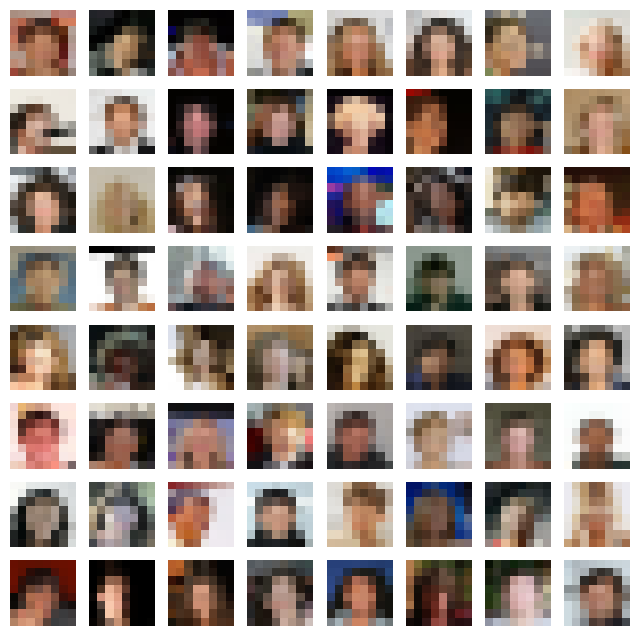

Fake: 


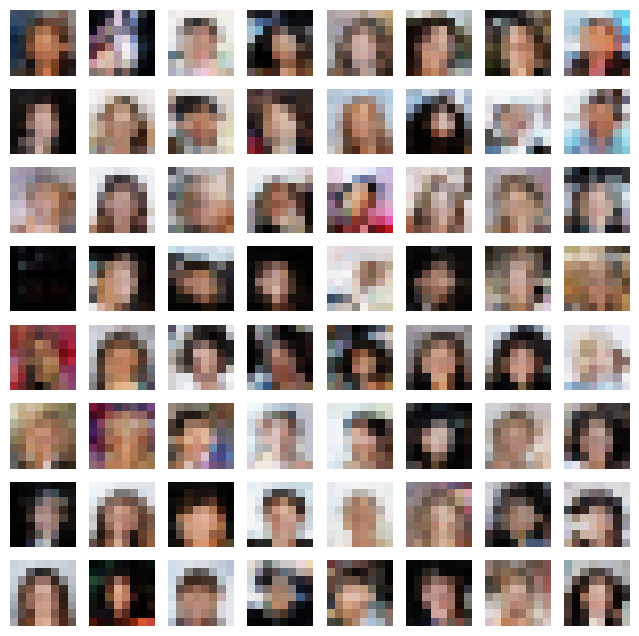

Final Alpha:  tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.39994827, shape=(), dtype=float32)
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - des_drift_loss: 0.0000e+00 - des_gradient_penalty: 0.0014 - des_loss: 1.9988 - des_main_loss: 1.9974 - gen_anchor_loss: 0.0000e+00 - gen_deviation_loss: 0.0000e+00 - gen_loss: 0.0265 - gen_main_loss: 0.0265
Starting epoch  11
Can update alpha for generator
Can update alpha for descriminator
Epoch 12/50
2537/2543 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - des_drift_loss: 0.0000e+00 - des_gradient_penalty: 0.0015 - des_loss: 1.9987 - des_main_loss: 1.9972 - gen_anchor_loss: 0.0000e+00 - gen_deviation_loss: 0.0000e+00 - gen_loss: 0.0304 - gen_main_loss: 0.0304
Epoch complete. Epoch Time:  18.084367990493774
Epoch  11 Descriminator Accuracy  0.5 Generator Loss  0.0005654142471030355
Real: 


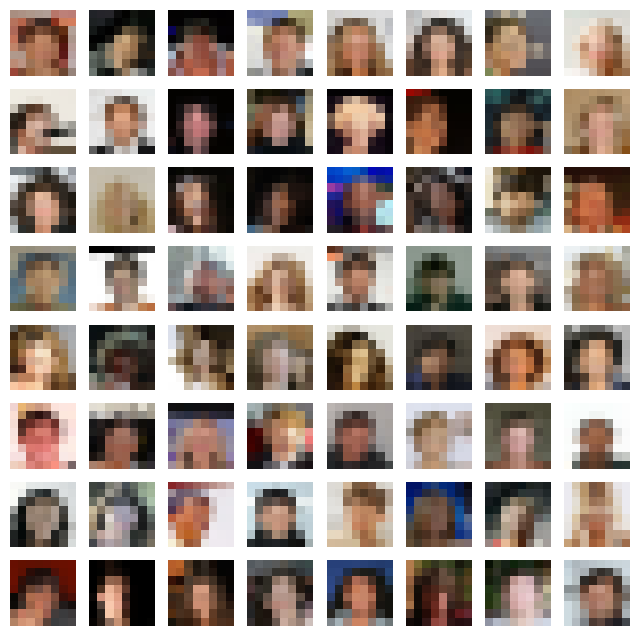

Fake: 


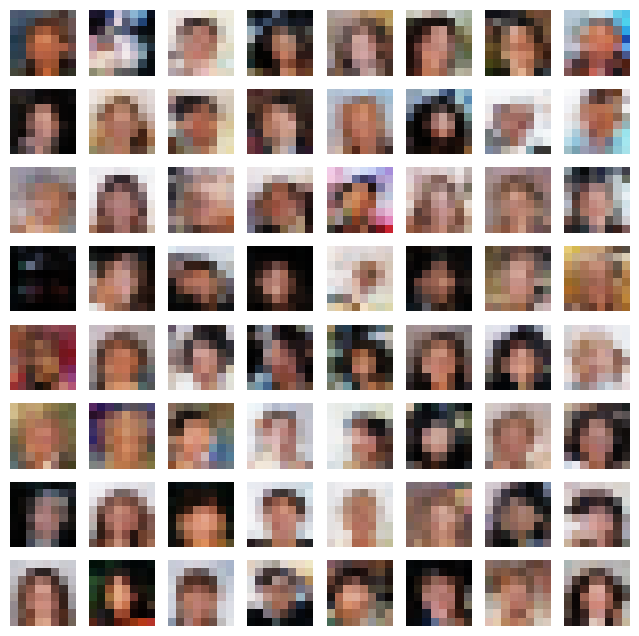

Final Alpha:  tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.49991173, shape=(), dtype=float32)
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - des_drift_loss: 0.0000e+00 - des_gradient_penalty: 0.0015 - des_loss: 1.9987 - des_main_loss: 1.9972 - gen_anchor_loss: 0.0000e+00 - gen_deviation_loss: 0.0000e+00 - gen_loss: 0.0304 - gen_main_loss: 0.0304
Starting epoch  12
Can update alpha for generator
Can update alpha for descriminator
Epoch 13/50
 259/2543 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - des_drift_loss: 0.0000e+00 - des_gradient_penalty: 0.0016 - des_loss: 1.9987 - des_main_loss: 1.9971 - gen_anchor_loss: 0.0000e+00 - gen_deviation_loss: 0.0000e+00 - gen_loss: 0.0319 - gen_main_loss: 0.0319

In [ ]:

def activation_builder():
    return layers.LeakyReLU(alpha=0.2)

def kernel_initializer_builder():
    return keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def upsampling_builder():
    return layers.UpSampling2D((2, 2), interpolation="nearest")

def gen_conv_normalizer(x, name=None):
    x.name = name
    return x

def des_normal_normalizer():
    return layers.GroupNormalization(groups=-1)

def des_conv_normalizer(*args, **kwargs):
    return SpectralNormalization(power_iterations=2, *args, **kwargs)

def optimizer_builder_des():
    return keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.0, beta_2=0.999)
    # return tf.keras.mixed_precision.LossScaleOptimizer(keras.optimizers.Adam(learning_rate=1e-4, beta_1 = 0., beta_2 = 0.999))


def optimizer_builder_gen():
    return keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.0, beta_2=0.999)
    # return tf.keras.mixed_precision.LossScaleOptimizer(keras.optimizers.Adam(learning_rate=5e-5, beta_1 = 0., beta_2 = 0.999))

trainingConfs = {
    "celeb_a": {
        4: {
            "epochs": 10,
            "batch_size": 64,
            "gen_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 0, "alpha_multiplier": 0.0}},
            "des_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 0, "alpha_multiplier": 0.0}},
        },
        8: {
            "epochs":50,
            "batch_size": 64,
            "gen_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.2, "alpha_delay": 0}},
            "des_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 7}},
        },
        16: {
            "epochs": 50,
            "batch_size": 64,
            "gen_grow_config": {"alpha_config":{"initial_alpha":1, "alpha_step": 0.2, "alpha_delay": 0}},
            "des_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 7}},
        },
        32: {
            "epochs": 50,
            "batch_size": 64,
            "gen_grow_config": {"alpha_config":{"initial_alpha":1, "alpha_step": 0.2, "alpha_delay": 0}},
            "des_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 7}},
        },
        64: {
            "epochs": 50,
            "batch_size": 32,
            "gen_grow_config": {"alpha_config":{"initial_alpha":1, "alpha_step": 0.2, "alpha_delay": 0}},
            "des_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 7}},
        },
        128: {
            "epochs": 50,
            "batch_size": 32,
            "gen_grow_config": {"alpha_config":{"initial_alpha":1, "alpha_step": 0.2, "alpha_delay": 0}},
            "des_grow_config": {"alpha_config":{"initial_alpha":0, "alpha_step": 0.1, "alpha_delay": 7}},
        },
    }
}
gen_config = {
    "latent_dim": 512,
    "conv_normalizer": gen_conv_normalizer,
    "normal_normalizer": PixelNorm,
    "activation_builder": activation_builder,
    "upsampling_builder": upsampling_builder,
    "kernel_constraint": None,
    "kernel_initializer_builder": kernel_initializer_builder,
    "freeze_oldlayers": False,
    "use_sepconv": True,
    "gen_grow_config": {
        "unfreeze_lower_layer_epoch": 5,
        "freeze_previous_output": False,
    },
}
des_config = {
    "conv_normalizer": des_conv_normalizer,
    "normal_normalizer": des_normal_normalizer,
    "activation_builder": activation_builder,
    "kernel_constraint": None,
    "kernel_initializer_builder": kernel_initializer_builder,
    "freeze_oldlayers": False,
    "use_sepconv": True,
}

config = {
    # "train_strategy": tf.distribute.OneDeviceStrategy(device="/gpu:0"),
    "clear_previous_runs": False,
    "profile": False,
    "des_steps": 1,
    "gen_steps": 1,
    "train_separately": True,
    "des_loss": descriminator_hinge_loss,
    "gen_loss": generator_hinge_loss,
    # 'des_loss':descriminator_softplus_loss,
    # 'gen_loss':generator_softplus_loss,
    "gradient_penalty_calculator": r1Penalty,
    "g_optimizer_builder": optimizer_builder_gen,
    "d_optimizer_builder": optimizer_builder_des,
    "data": "celeb_a",
    "gen_config": gen_config,
    "des_config": des_config,
    "loss_weights": {
        "gradient_penalty": 10,
        "drift": 0.00,
        "dev_loss": 0.0,
        "anchor_loss": 0.0,
    },
}
config["trainingProfile"] = trainingConfs[config["data"]]
trainProGan(name=MODEL_NAME, config=config, reportToWandb=True)

In [ ]:
dBuilder = DescriminatorBuilder(**des_config)
gBuilder = GeneratorBuilder(**gen_config)

In [ ]:
# keras.utils.plot_model(
#     gBuilder.current_model,
#     to_file="tmp.png",
#     expand_nested=True,
#     show_shapes=True,
#     show_layer_names=True,
#     dpi=96,
#     show_trainable=True,
# )

In [ ]:
for i in range(3):
    gBuilder.grow()

In [ ]:
for i in range(3):
    dBuilder.grow()

In [ ]:
fake_images = gBuilder.predict(tf.random.normal([1, 512], dtype=tf.float32))
real_images = tf.random.normal(fake_images.shape, dtype=tf.float32)

print(fake_images.dtype)

fake_output = dBuilder.model(fake_images)
real_output = dBuilder.model(real_images)

In [ ]:
tf.reduce_mean(fake_output), tf.reduce_mean(real_output)

In [ ]:
fake_output, real_output

In [ ]:
timeit.timeit(lambda: dBuilder.model( tf.random.normal(fake_images.shape)), number=100)/100

In [ ]:
timeit.timeit(lambda: dBuilder.model( tf.random.normal(fake_images.shape)), number=100)/100

In [ ]:
timeit.timeit(lambda: gBuilder.predict(tf.random.normal([1, 512])), number=100)/100

In [ ]:
dBuilder.model.summary()